In [1]:
from dotenv import load_dotenv
_ = load_dotenv("../.env")

In [2]:
import json
from typing import Annotated
from typing_extensions import TypedDict
from langchain_anthropic import ChatAnthropic
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, ToolMessage, AnyMessage

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

import geopandas as gpd

from IPython.display import Image, display

In [3]:
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")

In [4]:
loc_df = gpd.read_file("../data/gadm_410_small.gpkg")

In [5]:
query = "koraput"
match_df = gpd.read_file(
    "../data/gadm_410_small.gpkg",
    where=f"name like '%{query}%'")

In [6]:
match_df

,GID_0,GID_1,GID_2,GID_3,GID_4,GID_5,name,gadmid,geometry
0,IND,IND.26_1,IND.26.20_1,IND.26.20.1_1,,,Jaypur Koraput Odisha India,IND.26.20.1_1,"MULTIPOLYGON (((82.0849 18.73269, 82.08675 18...."
1,IND,IND.26_1,IND.26.20_1,IND.26.20.2_1,,,Koraput Odisha India,IND.26.20.2_1,"MULTIPOLYGON (((83.06583 18.39316, 83.06583 18..."


In [7]:
@tool
def location(query: str):
    "Returns location of a place"
    match_df = gpd.read_file(
        "../data/gadm_410_small.gpkg",
        where=f"name like '%{query}%'")
    return match_df.to_json()

In [8]:
tools = [location]
llm = llm.bind_tools(tools)

In [9]:
def should_continue(state):
    last_msg = state["messages"][-1]
    if not last_msg.tool_calls:
        return "end"
    else:
        return "continue"

def call_model(state):
    msgs = state["messages"]
    r = llm.invoke(msgs)
    return {"messages": [r]}

tool_node = ToolNode(tools)

In [10]:
wf = StateGraph(MessagesState)

wf.add_node("agent", call_model)
wf.add_node("action", tool_node)

wf.add_edge(START, "agent")
wf.add_conditional_edges("agent", should_continue, 
                         {"end": END,
                          "continue": "action"
                         })
wf.add_edge("action", "agent")

memory = MemorySaver()
graph = wf.compile(checkpointer=memory, interrupt_after=["action"])

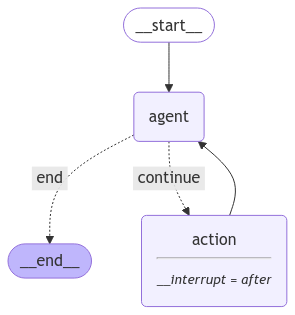

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="find location of koraput")]

for event in graph.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

find location of koraput
================================== Ai Message ==================================

[{'text': 'Certainly! I can help you find the location of Koraput using the available tool. Let me use the location function to get that information for you.', 'type': 'text'}, {'id': 'toolu_014buH2mtT2G6XHojxn8XUyn', 'input': {'query': 'Koraput'}, 'name': 'location', 'type': 'tool_use'}]
Tool Calls:
  location (toolu_014buH2mtT2G6XHojxn8XUyn)
 Call ID: toolu_014buH2mtT2G6XHojxn8XUyn
  Args:
    query: Koraput
================================= Tool Message =================================
Name: location

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"GID_0": "IND", "GID_1": "IND.26_1", "GID_2": "IND.26.20_1", "GID_3": "IND.26.20.1_1", "GID_4": "", "GID_5": "", "name": "Jaypur Koraput Odisha India", "gadmid": "IND.26.20.1_1"}, "geometry": {"type": "MultiPoly

In [13]:
cur_state = graph.get_state(thread)

In [14]:
options = gpd.read_file(cur_state.values["messages"][-1].content, driver="GeoJSON")

/Users/srm/workdir/projects/wri/project-zeno/.venv/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


In [17]:
for idx,row in options.iterrows():
    print(f"{idx}: {row['name']}")
selected_idx = int(input("Please enter the number of the option you choose: "))
selected_row = options.iloc[selected_idx]
selected_row


0: Jaypur Koraput Odisha India
1: Koraput Odisha India


id                                                          1
GID_0                                                     IND
GID_1                                                IND.26_1
GID_2                                             IND.26.20_1
GID_3                                           IND.26.20.2_1
GID_4                                                        
GID_5                                                        
name                                     Koraput Odisha India
gadmid                                          IND.26.20.2_1
geometry    MULTIPOLYGON (((83.0658264160001 18.3931598660...
Name: 1, dtype: object

In [19]:
feature = selected_row.geometry.__geo_interface__